<a href="https://colab.research.google.com/github/ghazicc/ML-Project2-Regression-Analysis-and-Model-Selection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [32]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

<ipython-input-60-91b4af18ec7f>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mean_imputed['cylinder'].fillna(mean_imputed['cylinder'].mean(), inplace=True)
<ipython-input-60-91b4af18ec7f>:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

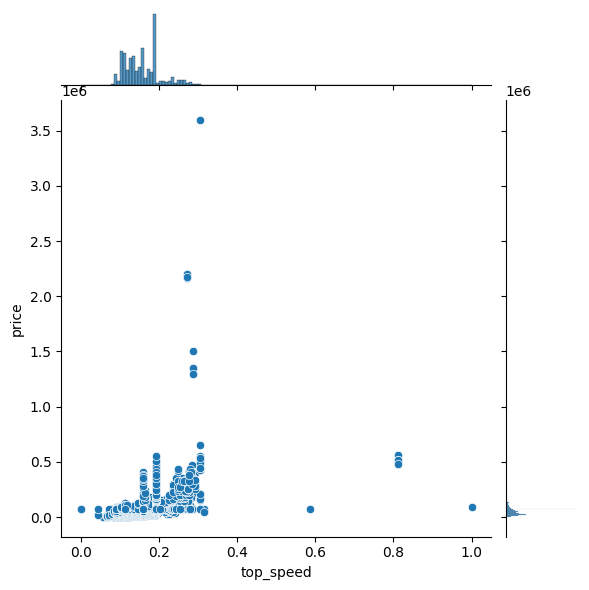

In [60]:
# print(pf.info()) #to print general info about the csv.
pf = pd.read_csv('cars.csv') #reading csv file.

mean_imputed = pf.copy()
# to clean dirty entries from cylinder column.

x =mean_imputed['cylinder'].unique()

for i in x:
    if isinstance(i,float) == False: #python descirdbe nan as float.
        if i.isnumeric() == False: #if the entry was string, replace it with null to replace it with the mean.
            mean_imputed.replace(i,None,inplace=True)

mean_imputed['cylinder'] = pd.to_numeric(mean_imputed['cylinder'], errors='coerce')

mean_imputed['cylinder'].fillna(mean_imputed['cylinder'].mean(), inplace=True)
pf= mean_imputed.copy()
del mean_imputed

#cylinder column now is clean.
#--------------------------------------------------------------------------------------------

#print(pf['engine_capacity'].unique()) #From this, I know that there are two types of dirty data in this column: 'cylinder' and large numbers such as 3000.
index = -1

for row in pf['engine_capacity']:
    index +=1
    if row == 'Cylinders':
        pf.loc[index,"engine_capacity"]= None
    elif i.isnumeric:
        if int(float(row)) > 20:
          pf.loc[index,"engine_capacity"]= None
        else:
          pf.loc[index,"engine_capacity"]= round(float(row),3)

pf['engine_capacity'].fillna(pf['engine_capacity'].mean(), inplace=True)

#engine capacity done.
#--------------------------------------------------------------------------------------------

#print(pf['horse_power'].unique())

index = -1
for row in pf['horse_power']:
    index+=1
    if 'Single' in row or 'Double' in row or 'Triple' in row or 'Horsepower (bhp)' in row:

        pf.loc[index,'horse_power']=None
    else:
        pf.loc[index,'horse_power']=int(row)

pf['horse_power'].fillna(pf['horse_power'].mean(), inplace=True)


#-------------------------------------------------------------
#Now i need to check and clean topspeed and seats coloumns
#if seates is bigger than 100, transfer this value to topspeed, and put None insted of it.
# print(pf['seats'].unique())
index = -1
num=''
for row in pf['seats']:
    index +=1
    if len(row) <= 4 and row!= 'N A':
        if int(float(row)) > 60:
            pf.loc[index,"top_speed"]=int(row)
            pf.loc[index,"seats"]=None
        elif int(float(row)) < 60:
            pf.loc[index,"seats"]=None
    elif 'Seater' in row:#if it contains 'seater' that's mean that this is a real number of seats.
            num = row[:2]
            pf.loc[index,"seats"]=int(num)
    else:
        pf.loc[index,"seats"]=None

pf['seats'].fillna(pf['seats'].median(), inplace=True)

#---------------------------------------------------------------------------
#top_speed
#this column contains string, seats, and numbers.
#seats must be transfered to 'seats' coloumn.
#strings must be discarded, numbers are good!!
index = -1
for row in pf['top_speed']:
    index+=1
    if 'Seater' in str(row):
        num = row[:2]
        pf.loc[index,"seats"]=int(num)
        pf.loc[index,'top_speed']=None
    elif str(row).isnumeric() == False:
        pf.loc[index,'top_speed']=None
    else:
        pf.loc[index,'top_speed']=int(row)

pf['top_speed'].fillna(int(pf['top_speed'].mean()), inplace=True)#221 insted of 221.22....


#hot encoding to country and brand, and normalize the price to
# print(pf['brand'].unique())
one_hot_encoded = pd.get_dummies(pf, columns=['country'])
pf = one_hot_encoded.copy()
del one_hot_encoded

# frequency-encode the car name feature, since one-hot encoding results in high dimensional sparse feature space
freq_encoding = pf['car name'].value_counts() / len(pf)
pf['car name'] = pf['car name'].map(freq_encoding)
freq_encoding = pf['brand'].value_counts() / len(pf)
pf['brand'] = pf['brand'].map(freq_encoding)

#--------------------------------------------------------------------------------------------
#changing all prices to USD with cleaning and filling the dirty with the mean.

# print(len(pd.unique(pf['price']))) # i noticed from this, that i can't use replace(row,new) in the for loop, because there is just 3350 uniqe value from 6300.

#pf.loc[1,'price']='moath' #I can use this to replace the value.

#Change the prices to USD and clean the dirty entries
index =-1
for row in pf['price']:
    index+=1
    if 'SAR' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.27

    elif 'EGP' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.02

    elif 'BHD' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 2.65

    elif 'QAR' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.27

    elif 'OMR' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 2.6

    elif 'KWD' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 3.25

    elif 'AED' in row:
        pf.loc[index,"price"]=int(row[4:].replace(',','')) * 0.27

    else:
        pf.loc[index,"price"]=None


#fill the null values with the mean of the coloumn.
pf['price'].fillna(pf['price'].mean(), inplace=True)

# drop rows containing null price values
# pf.dropna(subset=['price'], inplace=True)

#normalize the price, horsepower, and top_speed from 0 to 10

pf[['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats']] = MinMaxScaler(feature_range=(0, 1)).fit_transform(pf[['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats']])
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# print(pf.head(10))

sns.jointplot(x="top_speed", y='price',data=pf)

# sns.regplot(x='horse_power',y='price',data=pf,scatter_kws={'alpha' : 0.3})
plt.show()

In [61]:
pf.head()

,car name,price,engine_capacity,cylinder,horse_power,top_speed,seats,brand,country_bahrain,country_egypt,country_ksa,country_kuwait,country_oman,country_qatar,country_uae
0,0.001110,71351.016387,0.0000,0.184014,0.055632,0.079007,0.1875,0.008085,False,False,True,False,False,False,False
1,0.000476,37955.250000,0.2500,0.076923,0.033347,0.159142,0.3750,0.018548,False,False,True,False,False,False,False
2,0.000317,26671.950000,0.1875,0.076923,0.017864,0.073363,0.1250,0.010146,False,False,True,False,False,False,False
3,0.000951,53460.000000,0.2875,0.076923,0.080985,0.159142,0.1250,0.051205,False,False,True,False,False,False,False
4,0.000793,71351.016387,0.2250,0.076923,0.025407,0.124153,0.1875,0.020609,False,False,True,False,False,False,False


In [62]:
pf = pf.apply(pd.to_numeric, errors='coerce')
print(f"number of features: {len(pf.columns)}")
print(f"number of NaN values: {pf.isna().sum().sum()}")

number of features: 15
number of NaN values: 0


In [63]:
# Count non-numeric values
non_numeric_count = pf.applymap(lambda x: not pd.api.types.is_numeric_dtype(type(x))).sum().sum()

print(f"Number of non-numeric values: {non_numeric_count}")

Number of non-numeric values: 0


<ipython-input-63-d1a2bb8993b4>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  non_numeric_count = pf.applymap(lambda x: not pd.api.types.is_numeric_dtype(type(x))).sum().sum()


# Splitting the Dataset

In [64]:
# Split the dataset to training, validation and test sets
predictions = []
model_names = []

X = pf.drop('price', axis=1)
y = pf['price']

X = X.to_numpy(dtype=np.float32)
y = y.to_numpy(dtype=np.float32)

# First split the data set to 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Then split the the 80% part to 60/20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)




# Building Regression Models
Implementation of linear and nonlinear regression models

In [65]:
# Linear Regression by solving linear equations
# pinv is used because it is a singular matrix
w = np.linalg.pinv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
w = w.reshape(-1, 1)
y_pred = X_val.dot(w)
predictions.append(y_pred)
model_names.append("Linear Regression")


In [17]:

# Using Gradient Descent
learning_rate = 0.01
num_iterations = 1000
errors = []
W = np.random.randn(X_train.shape[1], 1) * 0.01  # Initialize W randomly
b = np.random.randn(1, 1) * 0.01  # Initialize b randomly
for i in range(num_iterations):
    # TODO: compute errors
    y_pred = np.matmul(X_train, W) + b
    difference = y - y_pred

    # TODO: compute steps
    W = W + learning_rate * np.matmul(X_train.T, difference) / X_train.size
    b = b + learning_rate * np.sum(difference) / X_train.size

    errors.append(np.mean(difference**2))
    if i % 100 == 0:
        print(f"Iteration {i}: Error = {errors[-1]}")

plt.figure(figsize=(10, 6))
plt.plot(range(num_iterations), errors)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Gradient Descent Error')
plt.legend()
plt.show()




# Feature Selection with Forward Selection Use a forward selection method to iteratively
# add features to the model, selecting features that improve model performance. The forward
# selection process will:
# o Start with an empty model and gradually add features one at a time.
# o At each step, add the feature that, when included, minimizes the error on the
# validation set.
# o Stop once additional features no longer improve the model performance or a
# maximum number of features is reached.


Iteration 0: Error = 14131235027.189936
Iteration 100: Error = 1.1633895642778659e+119


KeyboardInterrupt: 

In [66]:
# Polynomial Regression
for i in range(2, 5):
    poly = PolynomialFeatures(degree=i)
    # don't use fit_transform on validation and test sets to prevent data leakage
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)
    PolyRegression = LinearRegression()
    PolyRegression.fit(X_train_poly, y_train)
    y_pred = PolyRegression.predict(X_val_poly)
    predictions.append(y_pred)
    model_names.append(f"Polynomial Regression (degree={i})")

In [67]:

# Standard Gaussian Kernel (RBF)

rbf = SVR(kernel='rbf')
rbf.fit(X_train, y_train)
y_pred = rbf.predict(X_val)
predictions.append(y_pred)
model_names.append("RBF Kernel")

# Applying Regularization


In [68]:
# apply grid search to lasso and ridge reguralization techniques
lasso = Lasso()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_val, y_val)
lasso_regressor = lasso_regressor.best_estimator_

ridge = Ridge()
parameters = {'alpha': [0.1, 0.5, 1, 5, 10]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_regressor.fit(X_val, y_val)
ridge_regressor = ridge_regressor.best_estimator_

# fit the best model to the training data
lasso_regressor.fit(X_train, y_train)
ridge_regressor.fit(X_train, y_train)

model_names.append("Lasso")
predictions.append(lasso_regressor.predict(X_val))
model_names.append("Ridge")
predictions.append(ridge_regressor.predict(X_val))



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.701e+10, tolerance: 1.186e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+11, tolerance: 7.828e+08
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.234e+10, tolerance: 7.984e

# Model Evaluation

In [69]:

scores = {'MAE': [], 'MSE': [], 'R_squared': []}

for i in range(len(predictions)):
    scores['MAE'].append(mean_absolute_error(y_val, predictions[i]))
    scores['MSE'].append(mean_squared_error(y_val, predictions[i]))
    scores['R_squared'].append(r2_score(y_val, predictions[i]))

# Print the scores
print("Scores:")
for i in range(len(predictions)):
    print(f"{model_names[i]}:")
    print(f"  MAE: {scores['MAE'][i]}")
    print(f"  MSE: {scores['MSE'][i]}")
    print(f"  R-squared: {scores['R_squared'][i]}\n")

best_model_index = scores['R_squared'].index(max(scores['R_squared']))
print(f"The best model is {model_names[best_model_index]} with R-squared = {scores['R_squared'][best_model_index]}")







Scores:
Linear Regression:
  MAE: 28753.166015625
  MSE: 6649961472.0
  R-squared: 0.34918510913848877

Polynomial Regression (degree=2):
  MAE: 32573.673828125
  MSE: 5628175360.0
  R-squared: 0.44918471574783325

Polynomial Regression (degree=3):
  MAE: 26047.119140625
  MSE: 11296520192.0
  R-squared: -0.10556185245513916

Polynomial Regression (degree=4):
  MAE: 53298.7265625
  MSE: 533372567552.0
  R-squared: -51.199825286865234

RBF Kernel:
  MAE: 40001.714710592314
  MSE: 10331300533.398531
  R-squared: -0.011098387944558752

Lasso:
  MAE: 28745.451171875
  MSE: 6650451968.0
  R-squared: 0.3491370677947998

Ridge:
  MAE: 28757.90234375
  MSE: 6670304256.0
  R-squared: 0.34719419479370117

The best model is Polynomial Regression (degree=2) with R-squared = 0.44918471574783325


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y, )
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.title('Gradient Descent Error')
plt.legend()
plt.show()